In [0]:
%pip install pyvis 
%pip install pgmpy pymc arviz pandas networkx matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/756.0 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━ 307.2/756.0 kB 9.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 747.5/756.0 kB 11.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/47.1 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.4 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.0 MB ? eta -:--:--
   ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/2.0 MB 9.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━ 0.8/2.0 MB 11.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━ 1.4/2.0 MB 13.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 2.0/2.0 MB 15.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [0]:
dbutils.library.restartPython()

In [0]:
# ---------------------------------------------------------------------
# 0  Imports
# ---------------------------------------------------------------------

import pandas as pd
import numpy as np
import rapidmmm

from __future__ import annotations
import itertools
import pathlib
import warnings
from typing import List, Tuple, Dict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LinearRegression
from pgmpy.estimators import HillClimbSearch, BayesianEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.continuous import LinearGaussianCPD
from pgmpy.base import DAG

from pyvis.network import Network
import networkx as nx
import tempfile, webbrowser, os


INFO:py4j.clientserver:Received command c on object id p0
INFO:py4j.clientserver:Received command c on object id p0
INFO:py4j.clientserver:Received command c on object id p0
INFO:py4j.clientserver:Received command c on object id p0


In [0]:
import logging

logger = logging.getLogger("py4j")
logger.setLevel(logging.WARN)

In [0]:
from rapidmmm.PreProcessing.DataExploration import PlotlyVisualizer as pviz
from rapidmmm.PreProcessing.MarketingMetricsData import MarketingMetricsData
from rapidmmm.PreProcessing.BusinessMetricsData import BusinessMetricsData

In [0]:
marketing_query = f"""
            select 1000 as dmacode, 1000 as dma_regionid, 
case when tactic='Operational Emails' then 'NonMarketing' else  coalesce(core_campaign_super, campaign_super)  end  as campaign_super, 
case when channel = 'Email' and (tactic = 'Operational Emails' ) then 'Operational Emails'
when network = 'Google UAC' then 'App' 
else channel end as channel,
'None' as network, lob, tactic, 
coalesce(core_campaign_initiative, initiative) as initiative,
date, week_monday, impressions, clicks, spend 
from  marketing.marketingde_gold.mmm_marketing_metrics  
where week_monday between date'2024-01-01' and date'2025-06-30' 
and channel != 'OMP'
            """

business_query = f"""select 1000 as dma_regionid, 1000 as dmacode, date, week_monday, data_name, metric, value from marketing.marketingde_gold.mmm_business_metrics 
              where metric in ('visits','fs_submits')
                and date between date'2024-01-01' and date'2025-06-30'
        """

In [0]:
marketing_tbl = spark.sql(marketing_query)
business_tbl = spark.sql(business_query)

In [0]:
MD = MarketingMetricsData(QUERY=marketing_query,time_var='date')
MD.retrieve_data_and_clean()
MD.filter_date_range(start_date='2024-01-01', end_date='2025-06-30')
MD.channel_network_map

INFO:root:Default time variable set as date by default. 
 Change it to a different one if needed
INFO:root:This preprocessing works best with marketing.marketingde_gold.mmm_marketing_metrics data.
INFO:root:These columns are needed to use this module: 
 dma_regionid, dmacode, date, week_monday, campaign_super,
                        lob, tactic, channel, network, initiative, impressions, clicks, spend
INFO:root:if any of these are not present, either rename or add a dummy column with nulls
INFO:root:Levels not needed for each channel has been set as null
INFO:root:channel_network_map object updated
INFO:root:Date Range Changed for Object Data
         To revert, run retrieve_data_and_clean() again
INFO:root:channel_network_map object updated


{'Email': ['None'],
 'Operational Emails': ['None'],
 'SEM': ['None'],
 'Display': ['None'],
 'Owned Social': ['None'],
 'App': ['None'],
 'Push': ['null'],
 'TV': ['None'],
 'Paid Social': ['None'],
 'Media Solutions': ['None'],
 'Online Video': ['None'],
 'Native': ['None'],
 'Media Transformation': ['None'],
 'Audio': ['None']}

In [0]:
df_pivot_overall = MD.get_pivoted_impressions_for_mmm(columns=["channel", "network"])

In [0]:
collapsed_data_overall = MD.unpivot_data_for_mmm(df_pivot_overall)

INFO:root:multilevel columns collapsed into one level using | as separator


In [0]:
BD = BusinessMetricsData(QUERY=business_query,time_var='date')
BD.retrieve_data_and_clean()
BD.filter_date_range(start_date='2024-01-01', end_date='2025-06-30') #optional
BD.data_metric_map

INFO:root:Default time variable set as date. 
 Change it to daily if needed
INFO:root:Printing Query........ 
 select 1000 as dma_regionid, 1000 as dmacode, date, week_monday, data_name, metric, value from marketing.marketingde_gold.mmm_business_metrics 
              where metric in ('visits','fs_submits')
                and date between date'2024-01-01' and date'2025-06-30'
        
INFO:root:This module works best with marketing.marketingde_gold.mmm_business_metrics table
INFO:root:Query requires fields dma_regionid, dmacode, date, week_monday, data_name, metric, value.         If any of these is not present, include in the query, or have it as null field
INFO:root:Date Range Changed for Object Data
         To revert, run retrieve_data_and_clean() again


{'leads': ['fs_submits'], 'visits': ['visits']}

In [0]:
df_bd_pivot = BD.get_pivoted_data()

In [0]:
mmm_data = BD.unpivot_data_for_mmm(df_bd_pivot)

INFO:root:multilevel columns collapsed into one level using | as separator


In [0]:
final_overall = pd.merge(collapsed_data_overall, mmm_data,  how='outer', left_on=['dma_regionid','dmacode', 'date'], 
         right_on = ['dma_regionid','dmacode', 'date'])

In [0]:
final_overall.head()

,dma_regionid,dmacode,date,impressions|App|None,impressions|Audio|None,impressions|Display|None,impressions|Email|None,impressions|Media Solutions|None,impressions|Media Transformation|None,impressions|Native|None,impressions|Online Video|None,impressions|Operational Emails|None,impressions|Owned Social|None,impressions|Paid Social|None,impressions|Push|null,impressions|SEM|None,impressions|TV|None,spend|App|None,spend|Audio|None,spend|Display|None,spend|Media Solutions|None,spend|Media Transformation|None,spend|Native|None,spend|Online Video|None,spend|Owned Social|None,spend|Paid Social|None,spend|SEM|None,spend|TV|None,value|leads|fs_submits,value|visits|visits
0,1000,1000,2024-01-01,628889.000000,0,97893.000000,32680764.000000,9864399.000000,0,0,383798.000000,21916440.000000,560632.000000,8168475.000000,35322564.000000,1270101.000000,9522642.000000,26808.300040,0.0,2681.11,100455.130003,0.0,0.0,0.0,1463.069999,26096.195445,61922.19,0.0,27950.0,17962613.0
1,1000,1000,2024-01-02,635776.000000,0,171916.000000,46293790.000000,5861044.000000,0,0,400319.000000,27676053.000000,500689.000000,7332041.000000,45031927.000000,1707038.000000,863725.000000,29436.050002,0.0,3479.53,64287.290008,0.0,0.0,0.0,1574.619990,25377.860190,87743.18,0.0,38760.0,21931417.0
2,1000,1000,2024-01-03,532644.000000,0,277838.000000,47233042.000000,5077027.000000,0,0,398238.000000,27868975.000000,251222.000000,6165194.000000,43298061.000000,1877427.000000,852958.000000,23222.050005,0.0,5450.61,63868.000004,0.0,0.0,0.0,1265.359997,22974.448232,86621.37,0.0,39215.0,13254506.0
3,1000,1000,2024-01-04,389072.000000,0,211111.000000,46352265.000000,5149437.000000,0,0,416478.000000,29187255.000000,272587.000000,6070518.000000,44317455.000000,1915965.000000,527455.000000,20868.759970,0.0,4446.66,69041.060007,0.0,0.0,0.0,1312.390005,23037.992544,86081.71,0.0,39824.0,22245772.0
4,1000,1000,2024-01-05,363589.000000,0,130539.000000,67862827.000000,5115388.000000,0,0,384512.000000,30244702.000000,314634.000000,6222166.000000,41193133.000000,1834050.000000,505858.000000,18338.849983,0.0,3033.56,70520.680001,0.0,0.0,0.0,1849.369991,23124.295815,83356.91,0.0,40158.0,21514097.0


In [0]:
# Aggregate it to monthly level

month = [i.strftime('%Y-%m-01') for i in final_overall['date'].tolist()]

In [0]:
final_overall['month'] = month

In [0]:
# Let's just aggregate the marketing impression variables to a monthly level

aggregated = final_overall[['month'] + [i for i in final_overall.columns if i.startswith('impressions|')] + ['value|visits|visits','value|leads|fs_submits']].groupby('month').sum().reset_index()

In [0]:
display(aggregated)

month,impressions|App|None,impressions|Audio|None,impressions|Display|None,impressions|Email|None,impressions|Media Solutions|None,impressions|Media Transformation|None,impressions|Native|None,impressions|Online Video|None,impressions|Operational Emails|None,impressions|Owned Social|None,impressions|Paid Social|None,impressions|Push|null,impressions|SEM|None,impressions|TV|None,value|visits|visits,value|leads|fs_submits
2024-01-01,15418116.000000,0.000000,6046432.000000,1389711143.000000,141313189.000000,0.000000,0.000000,43317641.000000,795910962.000000,29987884.000000,180361887.000000,1268654564.000000,50912034.000000,14964913.000000,6.59262923E8,1164173.0
2024-02-01,21147175.000000,0.000000,2624475.000000,1374394752.000000,127365878.000000,0.000000,0.000000,207385449.000000,785563501.000000,32590991.000000,163930205.000000,1257050711.000000,50825612.000000,15116498.000000,6.61721641E8,1129000.0
2024-03-01,11103891.000000,0.000000,9819688.000000,1522981463.000000,132878494.000000,0.000000,0.000000,19928998.000000,870353729.000000,15409682.000000,164611075.000000,1377565023.000000,60407020.000000,517707617.000000,7.2538253E8,1204195.0
2024-04-01,13610015.000000,0.000000,2916103.000000,1511862713.000000,137975063.000000,0.000000,0.000000,40625320.000000,53768.000000,35497589.000000,203958287.000000,2582359087.000000,60206589.000000,523915281.000000,7.35893681E8,1132327.0
2024-05-01,14720158.000000,0.000000,83621725.000000,1633443174.000000,54404674.000000,0.000000,73437191.000000,133684130.000000,47779.000000,23239540.000000,314598652.000000,2700575751.000000,78881327.000000,512052156.000000,7.54676143E8,1147354.0
2024-06-01,35626522.000000,0.000000,114346459.000000,1611832876.000000,75130912.000000,0.000000,125769152.000000,202781783.000000,4564.000000,34586203.000000,452443362.000000,3161784981.000000,88594504.000000,522611203.000000,7.46391166E8,1160323.0
2024-07-01,44401237.000000,0.000000,173528238.000000,1647701767.000000,57053097.000000,0.000000,190298778.000000,346996309.000000,2652740.000000,61614003.000000,625399785.000000,2772789897.000000,93709829.000000,518932130.000000,7.66010647E8,1194345.0
2024-08-01,42728556.000000,0.000000,127572142.000000,1678392043.000000,88494061.000000,0.000000,105421009.000000,309479333.000000,3437.000000,72729109.000000,536586302.000000,1531127811.000000,92728354.000000,413858644.000000,7.48156451E8,1165328.0
2024-09-01,40630647.000000,0.000000,121325721.000000,1549507505.000000,123367385.000000,0.000000,87802328.000000,275968503.000000,1923.000000,49594478.000000,456840207.000000,1484954173.000000,90041140.000000,378044072.000000,6.97981995E8,1071919.0
2024-10-01,24465663.000000,0.000000,9756567.000000,1515006102.000000,134726917.000000,0.000000,0.000000,49480423.000000,420.000000,17376135.000000,118901812.000000,1468687780.000000,75927413.000000,651901214.000000,6.72338878E8,1017045.0


In [0]:
# Fix the column names

aggregated.columns = [col.replace('|', '_').replace(' ','') for col in aggregated.columns]

In [0]:
display(aggregated)

month,impressions_App_None,impressions_Audio_None,impressions_Display_None,impressions_Email_None,impressions_MediaSolutions_None,impressions_MediaTransformation_None,impressions_Native_None,impressions_OnlineVideo_None,impressions_OperationalEmails_None,impressions_OwnedSocial_None,impressions_PaidSocial_None,impressions_Push_null,impressions_SEM_None,impressions_TV_None,value_visits_visits,value_leads_fs_submits
2024-01-01,15418116.000000,0.000000,6046432.000000,1389711143.000000,141313189.000000,0.000000,0.000000,43317641.000000,795910962.000000,29987884.000000,180361887.000000,1268654564.000000,50912034.000000,14964913.000000,6.59262923E8,1164173.0
2024-02-01,21147175.000000,0.000000,2624475.000000,1374394752.000000,127365878.000000,0.000000,0.000000,207385449.000000,785563501.000000,32590991.000000,163930205.000000,1257050711.000000,50825612.000000,15116498.000000,6.61721641E8,1129000.0
2024-03-01,11103891.000000,0.000000,9819688.000000,1522981463.000000,132878494.000000,0.000000,0.000000,19928998.000000,870353729.000000,15409682.000000,164611075.000000,1377565023.000000,60407020.000000,517707617.000000,7.2538253E8,1204195.0
2024-04-01,13610015.000000,0.000000,2916103.000000,1511862713.000000,137975063.000000,0.000000,0.000000,40625320.000000,53768.000000,35497589.000000,203958287.000000,2582359087.000000,60206589.000000,523915281.000000,7.35893681E8,1132327.0
2024-05-01,14720158.000000,0.000000,83621725.000000,1633443174.000000,54404674.000000,0.000000,73437191.000000,133684130.000000,47779.000000,23239540.000000,314598652.000000,2700575751.000000,78881327.000000,512052156.000000,7.54676143E8,1147354.0
2024-06-01,35626522.000000,0.000000,114346459.000000,1611832876.000000,75130912.000000,0.000000,125769152.000000,202781783.000000,4564.000000,34586203.000000,452443362.000000,3161784981.000000,88594504.000000,522611203.000000,7.46391166E8,1160323.0
2024-07-01,44401237.000000,0.000000,173528238.000000,1647701767.000000,57053097.000000,0.000000,190298778.000000,346996309.000000,2652740.000000,61614003.000000,625399785.000000,2772789897.000000,93709829.000000,518932130.000000,7.66010647E8,1194345.0
2024-08-01,42728556.000000,0.000000,127572142.000000,1678392043.000000,88494061.000000,0.000000,105421009.000000,309479333.000000,3437.000000,72729109.000000,536586302.000000,1531127811.000000,92728354.000000,413858644.000000,7.48156451E8,1165328.0
2024-09-01,40630647.000000,0.000000,121325721.000000,1549507505.000000,123367385.000000,0.000000,87802328.000000,275968503.000000,1923.000000,49594478.000000,456840207.000000,1484954173.000000,90041140.000000,378044072.000000,6.97981995E8,1071919.0
2024-10-01,24465663.000000,0.000000,9756567.000000,1515006102.000000,134726917.000000,0.000000,0.000000,49480423.000000,420.000000,17376135.000000,118901812.000000,1468687780.000000,75927413.000000,651901214.000000,6.72338878E8,1017045.0


In [0]:
%sql

drop table if exists sandbox_desa.u_adityapu.bii_data_for_causal_analysis

In [0]:
# Write this to a table for me to pull it later

agg_sp = spark.createDataFrame(aggregated)

agg_sp.write.mode('overwrite').saveAsTable("sandbox_desa.u_adityapu.bii_data_for_causal_analysis")

In [0]:
aggregated = spark.read.table('sandbox_desa.u_adityapu.bii_data_for_causal_analysis').toPandas()
aggregated.head()

/databricks/spark/python/pyspark/sql/pandas/utils.py:149: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [impressions_App_None, impressions_Audio_None, impressions_Display_None, impressions_Email_None, impressions_MediaSolutions_None, impressions_MediaTransformation_None, impressions_Native_None, impressions_OnlineVideo_None, impressions_OperationalEmails_None, impressions_OwnedSocial_None, impressions_PaidSocial_None, impressions_Push_null, impressions_SEM_None, impressions_TV_None] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


,month,impressions_App_None,impressions_Audio_None,impressions_Display_None,impressions_Email_None,impressions_MediaSolutions_None,impressions_MediaTransformation_None,impressions_Native_None,impressions_OnlineVideo_None,impressions_OperationalEmails_None,impressions_OwnedSocial_None,impressions_PaidSocial_None,impressions_Push_null,impressions_SEM_None,impressions_TV_None,value_visits_visits,value_leads_fs_submits
0,2024-01-01,15418116.000000,0.000000,6046432.000000,1389711143.000000,141313189.000000,0.000000,0.000000,43317641.000000,795910962.000000,29987884.000000,180361887.000000,1268654564.000000,50912034.000000,14964913.000000,659262923.0,1164173.0
1,2024-02-01,21147175.000000,0.000000,2624475.000000,1374394752.000000,127365878.000000,0.000000,0.000000,207385449.000000,785563501.000000,32590991.000000,163930205.000000,1257050711.000000,50825612.000000,15116498.000000,661721641.0,1129000.0
2,2024-03-01,11103891.000000,0.000000,9819688.000000,1522981463.000000,132878494.000000,0.000000,0.000000,19928998.000000,870353729.000000,15409682.000000,164611075.000000,1377565023.000000,60407020.000000,517707617.000000,725382530.0,1204195.0
3,2024-04-01,13610015.000000,0.000000,2916103.000000,1511862713.000000,137975063.000000,0.000000,0.000000,40625320.000000,53768.000000,35497589.000000,203958287.000000,2582359087.000000,60206589.000000,523915281.000000,735893681.0,1132327.0
4,2024-05-01,14720158.000000,0.000000,83621725.000000,1633443174.000000,54404674.000000,0.000000,73437191.000000,133684130.000000,47779.000000,23239540.000000,314598652.000000,2700575751.000000,78881327.000000,512052156.000000,754676143.0,1147354.0


In [0]:
# Also pull the monthly BII score;

bii = spark.read.table('sandbox_desa.mads_team.brand_science_bii_score').toPandas()
bii.head()

,Month,bii_score
0,2024-01-01,0.952543
1,2024-02-01,0.993713
2,2024-03-01,0.979362
3,2024-04-01,1.002487
4,2024-05-01,0.988938


In [0]:
bii.columns = ['month','bii_score']

In [0]:
aggregated = aggregated.merge(bii, on = 'month')

In [0]:
# We need to scale the data; I would just use range scaling for now

from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()

In [0]:
aggregated

,month,impressions_App_None,impressions_Audio_None,impressions_Display_None,impressions_Email_None,impressions_MediaSolutions_None,impressions_MediaTransformation_None,impressions_Native_None,impressions_OnlineVideo_None,impressions_OperationalEmails_None,impressions_OwnedSocial_None,impressions_PaidSocial_None,impressions_Push_null,impressions_SEM_None,impressions_TV_None,value_visits_visits,value_leads_fs_submits,bii_score
0,2024-01-01,15418116.000000,0.000000,6046432.000000,1389711143.000000,141313189.000000,0.000000,0.000000,43317641.000000,795910962.000000,29987884.000000,180361887.000000,1268654564.000000,50912034.000000,14964913.000000,659262923.0,1164173.0,0.952543
1,2024-02-01,21147175.000000,0.000000,2624475.000000,1374394752.000000,127365878.000000,0.000000,0.000000,207385449.000000,785563501.000000,32590991.000000,163930205.000000,1257050711.000000,50825612.000000,15116498.000000,661721641.0,1129000.0,0.993713
2,2024-03-01,11103891.000000,0.000000,9819688.000000,1522981463.000000,132878494.000000,0.000000,0.000000,19928998.000000,870353729.000000,15409682.000000,164611075.000000,1377565023.000000,60407020.000000,517707617.000000,725382530.0,1204195.0,0.979362
3,2024-04-01,13610015.000000,0.000000,2916103.000000,1511862713.000000,137975063.000000,0.000000,0.000000,40625320.000000,53768.000000,35497589.000000,203958287.000000,2582359087.000000,60206589.000000,523915281.000000,735893681.0,1132327.0,1.002487
4,2024-05-01,14720158.000000,0.000000,83621725.000000,1633443174.000000,54404674.000000,0.000000,73437191.000000,133684130.000000,47779.000000,23239540.000000,314598652.000000,2700575751.000000,78881327.000000,512052156.000000,754676143.0,1147354.0,0.988938
5,2024-06-01,35626522.000000,0.000000,114346459.000000,1611832876.000000,75130912.000000,0.000000,125769152.000000,202781783.000000,4564.000000,34586203.000000,452443362.000000,3161784981.000000,88594504.000000,522611203.000000,746391166.0,1160323.0,0.944034
6,2024-07-01,44401237.000000,0.000000,173528238.000000,1647701767.000000,57053097.000000,0.000000,190298778.000000,346996309.000000,2652740.000000,61614003.000000,625399785.000000,2772789897.000000,93709829.000000,518932130.000000,766010647.0,1194345.0,0.979109
7,2024-08-01,42728556.000000,0.000000,127572142.000000,1678392043.000000,88494061.000000,0.000000,105421009.000000,309479333.000000,3437.000000,72729109.000000,536586302.000000,1531127811.000000,92728354.000000,413858644.000000,748156451.0,1165328.0,0.984581
8,2024-09-01,40630647.000000,0.000000,121325721.000000,1549507505.000000,123367385.000000,0.000000,87802328.000000,275968503.000000,1923.000000,49594478.000000,456840207.000000,1484954173.000000,90041140.000000,378044072.000000,697981995.0,1071919.0,1.008777
9,2024-10-01,24465663.000000,0.000000,9756567.000000,1515006102.000000,134726917.000000,0.000000,0.000000,49480423.000000,420.000000,17376135.000000,118901812.000000,1468687780.000000,75927413.000000,651901214.000000,672338878.0,1017045.0,0.998062


In [0]:
scaled = pd.DataFrame(scaler.fit_transform(aggregated[[i for i in aggregated.columns if i.startswith('impressions')]+['value_visits_visits','value_leads_fs_submits']].values))

In [0]:
bii

,month,bii_score
0,2024-01-01,0.952543
1,2024-02-01,0.993713
2,2024-03-01,0.979362
3,2024-04-01,1.002487
4,2024-05-01,0.988938
5,2024-06-01,0.944034
6,2024-07-01,0.979109
7,2024-08-01,0.984581
8,2024-09-01,1.008777
9,2024-10-01,0.998062


In [0]:
scaled.columns = [i for i in aggregated.columns if i.startswith('impressions')]+['value_visits_visits','value_leads_fs_submits']

In [0]:
scaled['bii_score'] = bii['bii_score']

In [0]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(y=scaled['bii_score'], name='bii_score', yaxis='y1'))
fig.add_trace(go.Scatter(y=scaled['value_visits_visits'], name='value_visits_visits', yaxis='y2'))

fig.update_layout(
    yaxis=dict(title='bii_score'),
    yaxis2=dict(title='value_visits_visits', overlaying='y', side='right'),
    xaxis=dict(title='Index'),
    legend=dict(x=0.01, y=0.99)
)
fig.show()

In [0]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(y=scaled['bii_score'], name='bii_score', yaxis='y1'))
fig.add_trace(go.Scatter(y=scaled['value_leads_fs_submits'], name='value_leads_fs_submits', yaxis='y2'))

fig.update_layout(
    yaxis=dict(title='bii_score'),
    yaxis2=dict(title='value_leads_fs_submits', overlaying='y', side='right'),
    xaxis=dict(title='Index'),
    legend=dict(x=0.01, y=0.99)
)
fig.show()

In [0]:
# There seems to be a lagged correlation of bii_score on the fs submits;

In [0]:
visits = spark.sql("""select date_trunc('month', date) as month, sum(value) visits from marketing.marketingde_gold.mmm_business_metrics
                   where metric = 'visits' group by date_trunc('month', date) order by month""")
visits = visits.toPandas()
visits.head()


,month,visits
0,2020-01-01,589395193.0
1,2020-02-01,584401212.0
2,2020-03-01,583106822.0
3,2020-04-01,605026017.0
4,2020-05-01,760839578.0


<Axes: >

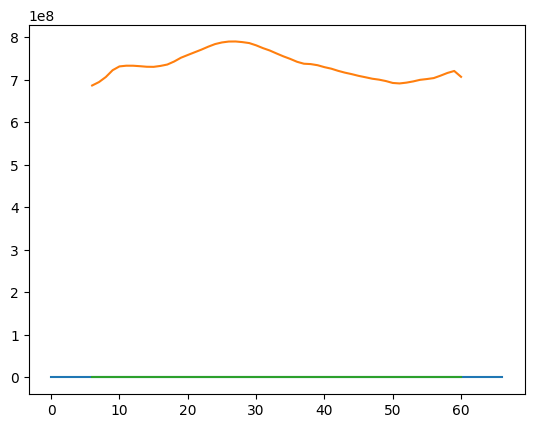

In [0]:
# How do I extract monthly seasonality from this?

from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(visits['visits'], model='multiplicative', period=12)
decomposed.seasonal.plot()
decomposed.trend.plot()
decomposed.resid.plot()

In [0]:
visits['seasonal'] = decomposed.seasonal

In [0]:
scaled.index = aggregated['month']

In [0]:
visits['month'] = visits['month'].astype(str)

In [0]:
scaled.reset_index(inplace = True)



In [0]:
scaled = scaled.merge(visits[['month','seasonal']], on = 'month')

In [0]:
scaled.drop(columns = ['month'], axis = 1, inplace = True)

In [0]:
scaled

,impressions_App_None,impressions_Audio_None,impressions_Display_None,impressions_Email_None,impressions_MediaSolutions_None,impressions_MediaTransformation_None,impressions_Native_None,impressions_OnlineVideo_None,impressions_OperationalEmails_None,impressions_OwnedSocial_None,impressions_PaidSocial_None,impressions_Push_null,impressions_SEM_None,impressions_TV_None,value_visits_visits,value_leads_fs_submits,bii_score,seasonal
0,0.129567,0.000000,0.020023,0.050383,0.731748,0.000000,0.000000,0.071510,9.144683e-01,0.350314,0.121343,0.006092,0.080545,0.005163,0.287160,0.871775,0.952543,0.988850
1,0.301624,0.000000,0.000000,0.000000,0.614315,0.000000,0.000000,0.573143,9.025795e-01,0.389883,0.088901,0.000000,0.078981,0.005400,0.297662,0.759085,0.993713,0.929040
2,0.000000,0.000000,0.042101,0.488776,0.660730,0.000000,0.000000,0.000000,1.000000e+00,0.128719,0.090246,0.063271,0.252356,0.790402,0.569570,1.000000,0.979362,1.066404
3,0.075265,0.000000,0.001706,0.452201,0.703642,0.000000,0.000000,0.063278,6.129465e-05,0.434064,0.167931,0.695797,0.248729,0.800098,0.614465,0.769745,1.002487,1.067724
4,0.108605,0.000000,0.473935,0.852141,0.000000,0.000000,0.385905,0.347803,5.441353e-05,0.247736,0.386372,0.757862,0.586647,0.781568,0.694689,0.817889,0.988938,1.086393
5,0.736474,0.000000,0.653713,0.781053,0.174510,0.000000,0.660904,0.559068,4.761285e-06,0.420211,0.658525,1.000000,0.762406,0.798061,0.659302,0.859440,0.944034,1.069511
6,1.000000,0.000000,1.000000,0.899044,0.022299,0.000000,1.000000,1.000000,3.047406e-03,0.831045,1.000000,0.795775,0.854967,0.792314,0.743101,0.968442,0.979109,1.110735
7,0.949765,0.000000,0.731100,1.000000,0.287024,0.000000,0.553976,0.885293,3.466408e-06,1.000000,0.824652,0.143893,0.837208,0.628199,0.666842,0.875475,0.984581,1.098333
8,0.886760,0.000000,0.694550,0.576034,0.580649,0.000000,0.461392,0.782834,1.726885e-06,0.648343,0.667206,0.119651,0.788583,0.572260,0.452537,0.576206,1.008777,0.995306
9,0.401286,0.000000,0.041732,0.462541,0.676293,0.000000,0.000000,0.090353,0.000000e+00,0.158610,0.000000,0.111111,0.533196,1.000000,0.343010,0.400397,0.998062,0.951219


In [0]:
import plotly.express as px

corr_matrix = scaled.corr()
fig = px.imshow(corr_matrix, text_auto=True, color_continuous_scale='RdBu', zmin=-1, zmax=1)
fig.update_layout(title="Correlation Heatmap of Scaled DataFrame", autosize=True, width=1000, height=800)
fig.show()

In [0]:

DEPENDENT_VAR   = "value_leads_fs_submits"             # outcome column
CONTINUOUS_COLS = [i for i in aggregated.columns if i.startswith('impressions')] + ['bii_score']    # treat these as Gaussian targets
BINS            = 4               # bins for discretising *other* vars
ESS             = 100              # equivalent sample size for BDeu
MAX_INDEGREE    = 5               # None = no cap
SOFT_SIGMA      = 0.4             # σ of Half-Normal coefficient prior
NUM_SAMPLES     = 2000            # PyMC draws (posterior)
NUM_TUNE        = 1000            # PyMC warm-up


In [0]:
scaled.columns

Index(['impressions_App_None', 'impressions_Audio_None',
       'impressions_Display_None', 'impressions_Email_None',
       'impressions_MediaSolutions_None',
       'impressions_MediaTransformation_None', 'impressions_Native_None',
       'impressions_OnlineVideo_None', 'impressions_OperationalEmails_None',
       'impressions_OwnedSocial_None', 'impressions_PaidSocial_None',
       'impressions_Push_null', 'impressions_SEM_None', 'impressions_TV_None',
       'value_visits_visits', 'value_leads_fs_submits', 'bii_score',
       'seasonal'],
      dtype='object')

In [0]:
MUST_EDGES   : List[Tuple[str, str]] = [
    ("bii_score", "value_visits_visits"),
    ("impressions_TV_None",'bii_score'),
    ("impressions_TV_None",'impressions_SEM_None'),
    ('impressions_SEM_None','value_visits_visits'),
    ("seasonal",'value_visits_visits'),
    ("bii_score",'impressions_SEM_None'),
    ("value_visits_visits",'value_leads_fs_submits'),
    ] + [(i,'value_visits_visits') for i in scaled.columns if i.startswith('impressions_')]

FORBID_EDGES : List[Tuple[str, str]] = [("value_visits_visits","bii_score"),("bii_score","impressions_TV_None")] + [('value_visits_visits',i) for i in scaled.columns if i.startswith('impressions_')] 

SOFT_PRIORS  : Dict[Tuple[str, str], float] = {
    ("seasonal",'value_visits_visits'): +3.75,
    ("impressions_TV_None",'bii_score'): +2.0,
    ('bii_score','value_visits_visits'): +1.75,
    ('bii_score','impressions_SEM_None'): +2.5,
    ('bii_score','impressions_PaidSocial_None'): +2,
    ('impressions_App_None', 'value_visits_visits'): 1,
 ('impressions_Audio_None', 'value_visits_visits'): 1,
 ('impressions_Display_None', 'value_visits_visits'): 1,
 ('impressions_Email_None', 'value_visits_visits'): 1,
 ('impressions_MediaSolutions_None', 'value_visits_visits'): 1,
 ('impressions_MediaTransformation_None', 'value_visits_visits'): 1,
 ('impressions_Native_None', 'value_visits_visits'): 1,
 ('impressions_OnlineVideo_None', 'value_visits_visits'): 1.5,
 ('impressions_OperationalEmails_None', 'value_visits_visits'): 3,
 ('impressions_OwnedSocial_None', 'value_visits_visits'): 1,
 ('impressions_PaidSocial_None', 'value_visits_visits'): 3.5,
 ('impressions_Push_null', 'value_visits_visits'): 1,
 ('impressions_SEM_None', 'value_visits_visits'): 3.5,
 ('value_visits_visits', 'value_leads_fs_submits'): 4,
 ('impressions_PaidSocial_None', 'value_leads_fs_submits'): 2,
 ('impressions_SEM_None', 'value_leads_fs_submits'): 2,
 ('seasonal', 'value_leads_fs_submits'): 3,
                                               }

OUTPUT_DAG_IMG = "dag.png"

In [0]:
SOFT_PRIORS  : Dict[Tuple[str, str], float] = {
    ("seasonal",'value_visits_visits'): +3.75,

                                               }

In [0]:
import pgmpy

from pgmpy.estimators import BDeu

In [0]:
print(pgmpy.__version__)

1.0.0


In [0]:
class ConstrainedBDeu(BDeu):
    def __init__(self, data, equivalent_sample_size=10,
                 edge_priors=None,
                 required_edges=None,
                 forbidden_edges=None,
                 big_penalty=1e6):
        super().__init__(data, equivalent_sample_size=equivalent_sample_size)
        self.edge_priors     = edge_priors or {}
        self.required_edges  = set(required_edges or [])
        self.forbidden_edges = set(forbidden_edges or [])
        self.big_penalty     = big_penalty

    def local_score(self, variable, parents):
        # base BDeu score
        score = super().local_score(variable, parents)

        # add soft priors
        for p in parents:
            score += self.edge_priors.get((p, variable), 0.0)

        # HARD constraint: required edge missing → huge NEG penalty
        for (req_parent, req_child) in self.required_edges:
            if req_child == variable and req_parent not in parents:
                score -= self.big_penalty

        # HARD constraint: forbidden edge present → huge NEG penalty
        for (bad_parent, bad_child) in self.forbidden_edges:
            if bad_child == variable and bad_parent in parents:
                score -= self.big_penalty

        return score


In [0]:
#scaled = scaled.drop('value_leads_fs_submits', axis=1)

In [0]:

score = ConstrainedBDeu(scaled,
                        equivalent_sample_size=ESS,
                        edge_priors=SOFT_PRIORS,
                        required_edges=MUST_EDGES,
                        forbidden_edges=FORBID_EDGES)

# ---------- structure learning ----------------------------------
hc = HillClimbSearch(scaled)
model: BayesianNetwork = hc.estimate(
        scoring_method=score,
        max_indegree=3,
        tabu_length=60,
        epsilon=1e-3)

print("Learned edges:", list(model.edges()))

# ---------- parameter learning (discrete example) ---------------


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'impressions_App_None': 'N', 'impressions_Audio_None': 'N', 'impressions_Display_None': 'N', 'impressions_Email_None': 'N', 'impressions_MediaSolutions_None': 'N', 'impressions_MediaTransformation_None': 'N', 'impressions_Native_None': 'N', 'impressions_OnlineVideo_None': 'N', 'impressions_OperationalEmails_None': 'N', 'impressions_OwnedSocial_None': 'N', 'impressions_PaidSocial_None': 'N', 'impressions_Push_null': 'N', 'impressions_SEM_None': 'N', 'impressions_TV_None': 'N', 'value_visits_visits': 'N', 'value_leads_fs_submits': 'N', 'bii_score': 'N', 'seasonal': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'impressions_App_None': 'N', 'impressions_Audio_None': 'N', 'impressions_Display_None': 'N', 'impressions_Email_None': 'N', 'impressions_MediaSolutions_None': 'N', 'impressions_MediaTransformation_None': 'N', 'imp

  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned edges: [('impressions_App_None', 'impressions_MediaSolutions_None'), ('impressions_Display_None', 'impressions_TV_None'), ('impressions_Email_None', 'impressions_Push_null'), ('impressions_MediaSolutions_None', 'impressions_Display_None'), ('impressions_MediaSolutions_None', 'impressions_OperationalEmails_None'), ('impressions_MediaTransformation_None', 'impressions_Audio_None'), ('impressions_MediaTransformation_None', 'impressions_Native_None'), ('impressions_Native_None', 'impressions_Audio_None'), ('impressions_OnlineVideo_None', 'value_visits_visits'), ('impressions_OwnedSocial_None', 'impressions_PaidSocial_None'), ('impressions_OwnedSocial_None', 'seasonal'), ('impressions_PaidSocial_None', 'impressions_OnlineVideo_None'), ('impressions_PaidSocial_None', 'impressions_App_None'), ('impressions_Push_null', 'value_visits_visits'), ('impressions_SEM_None', 'impressions_Email_None'), ('impressions_TV_None', 'bii_score'), ('impressions_TV_None', 'impressions_SEM_None'), ('valu

In [0]:
score = ConstrainedBDeu(scaled,
                        equivalent_sample_size=ESS,
                        edge_priors=None,
                        required_edges=MUST_EDGES,
                        forbidden_edges=FORBID_EDGES)

# ---------- structure learning ----------------------------------
hc = HillClimbSearch(scaled)
model: BayesianNetwork = hc.estimate(
        scoring_method=score,
        max_indegree=3,
        tabu_length=60,
        epsilon=1e-3)

print("Learned edges:", list(model.edges()))


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'impressions_App_None': 'N', 'impressions_Audio_None': 'N', 'impressions_Display_None': 'N', 'impressions_Email_None': 'N', 'impressions_MediaSolutions_None': 'N', 'impressions_MediaTransformation_None': 'N', 'impressions_Native_None': 'N', 'impressions_OnlineVideo_None': 'N', 'impressions_OperationalEmails_None': 'N', 'impressions_OwnedSocial_None': 'N', 'impressions_PaidSocial_None': 'N', 'impressions_Push_null': 'N', 'impressions_SEM_None': 'N', 'impressions_TV_None': 'N', 'value_visits_visits': 'N', 'value_leads_fs_submits': 'N', 'bii_score': 'N', 'seasonal': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'impressions_App_None': 'N', 'impressions_Audio_None': 'N', 'impressions_Display_None': 'N', 'impressions_Email_None': 'N', 'impressions_MediaSolutions_None': 'N', 'impressions_MediaTransformation_None': 'N', 'imp

  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned edges: [('impressions_App_None', 'impressions_MediaSolutions_None'), ('impressions_Display_None', 'impressions_TV_None'), ('impressions_Email_None', 'impressions_Push_null'), ('impressions_MediaSolutions_None', 'value_visits_visits'), ('impressions_MediaSolutions_None', 'impressions_Display_None'), ('impressions_MediaSolutions_None', 'impressions_OperationalEmails_None'), ('impressions_MediaTransformation_None', 'impressions_Audio_None'), ('impressions_MediaTransformation_None', 'impressions_Native_None'), ('impressions_Native_None', 'impressions_Audio_None'), ('impressions_OnlineVideo_None', 'value_visits_visits'), ('impressions_OwnedSocial_None', 'impressions_PaidSocial_None'), ('impressions_OwnedSocial_None', 'seasonal'), ('impressions_PaidSocial_None', 'impressions_OnlineVideo_None'), ('impressions_PaidSocial_None', 'impressions_App_None'), ('impressions_Push_null', 'value_visits_visits'), ('impressions_SEM_None', 'impressions_Email_None'), ('impressions_TV_None', 'bii_scor

In [0]:
model.fit(scaled,
          estimator=BayesianEstimator,
          prior_type="BDeu",
          equivalent_sample_size=ESS)



INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'impressions_App_None': 'N', 'impressions_Audio_None': 'N', 'impressions_Display_None': 'N', 'impressions_Email_None': 'N', 'impressions_MediaSolutions_None': 'N', 'impressions_MediaTransformation_None': 'N', 'impressions_Native_None': 'N', 'impressions_OnlineVideo_None': 'N', 'impressions_OperationalEmails_None': 'N', 'impressions_OwnedSocial_None': 'N', 'impressions_PaidSocial_None': 'N', 'impressions_Push_null': 'N', 'impressions_SEM_None': 'N', 'impressions_TV_None': 'N', 'value_visits_visits': 'N', 'value_leads_fs_submits': 'N', 'bii_score': 'N', 'seasonal': 'N'}


In [0]:
from pyvis.network import Network
import networkx as nx

# ------------------------------------------------------------------
# 1. build the PyVis graph from your NetworkX DiGraph
net = Network(height="750px", width="100%", directed=True)
net.from_nx(nx.DiGraph(model.edges()))

# ------------------------------------------------------------------
# 2. baseline style for every node / edge
for n in net.nodes:
    n["size"] = 24
    n["color"] = "#e7f0ff"       # light blue
    n["borderWidth"] = 2
    n["font"] = {"size": 18}

for e in net.edges:
    e["arrows"] = "to"

# ------------------------------------------------------------------
# 3. highlight table  (node_id → color, size, border)
HIGHLIGHT = {
    "bii_score":               {"color": "#FFD54F", "size": 40},  # gold
    "value_visits_visits":     {"color": "#42A5F5", "size": 40},  # bright blue
    "value_leads_fs_submits":  {"color": "#EF5350", "size": 40},  # tomato red
}

for n in net.nodes:
    nid = n["id"]              # node name as stored by PyVis
    if nid in HIGHLIGHT:
        style = HIGHLIGHT[nid]
        n["color"]       = style["color"]
        n["size"]        = style["size"]
        n["borderWidth"] = 4
        n["font"]["bold"] = True
        n["font"]["size"] = 22

# ------------------------------------------------------------------
net.show_buttons(filter_=['physics'])
net.save_graph("dag_highlight.html")

# Display inside notebook (Databricks / Colab etc.)
with open("dag_highlight.html") as f:
    displayHTML(f.read())


<!-- 
-->

In [0]:
# ---------- quick interactive DAG via PyVis ---------------------
net = Network(height="750px", width="100%", directed=True)
net.from_nx(nx.DiGraph(model.edges()))
for n in net.nodes:                      # simple styling
    n["size"] = 24; n["color"] = "#e7f0ff"; n["borderWidth"] = 2
for e in net.edges:
    e["arrows"] = "to"
net.show_buttons(filter_=['physics'])

# Save the HTML to a file
net.save_graph("dag.html")

# Display the HTML file in the notebook
with open("dag.html", "r") as f:
    html_content = f.read()
displayHTML(html_content)


<!-- 
-->

In [0]:
DV = "value_visits_visits"
print("Parents of DV  :", model.get_parents(DV))
print("Children of DV :", model.get_children(DV))

Parents of DV  : ['seasonal', 'impressions_OnlineVideo_None', 'impressions_Push_null']
Children of DV : ['value_leads_fs_submits']


In [0]:
import pymc as pm

In [0]:
import pymc as pm
import numpy as np
import pandas as pd
from pgmpy.factors.continuous import LinearGaussianCPD
from pgmpy.models import LinearGaussianBayesianNetwork


def bayes_linear_cpds(
        model          : LinearGaussianBayesianNetwork,
        df_raw         : pd.DataFrame,
        sigma_p        : float = 1.0,      # Half-Normal(σ) prior for βj ≥ 0 (soft)
        n_draws        : int   = 2000,
        n_tune         : int   = 1000,
        seed           : int   = 44,
        continuous_cols: list[str] | None = None,
):
    """
    For each *continuous* child Y with parents X₁…Xₖ, fit

        Y = β₀ + Σ βⱼ Xⱼ + ε,  ε ~ N(0, σ²)
        βⱼ ~ HalfNormal(σ_p)

    and insert a LinearGaussianCPD with posterior-mean parameters
    into the LinearGaussianBayesianNetwork `model`.
    """
    continuous_cols = continuous_cols or list(df_raw.columns)

    for child in continuous_cols:
        if child not in model.nodes:
            continue

        parents = list(model.get_parents(child))
        if not parents:                      # root node → no regression to fit
            continue

        X = df_raw[parents].values
        y = df_raw[child].values
        k = X.shape[1]

        # ── PyMC linear-Gaussian with Half-Normal priors ──────────────────
        with pm.Model() as lm:
            β0 = pm.Normal("β0", mu=0, sigma=10)
            β  = pm.HalfNormal("β", sigma=sigma_p, shape=k)
            σ  = pm.HalfNormal("σ", sigma=1.0)

            μ  = β0 + pm.math.dot(X, β)
            pm.Normal("y", mu=μ, sigma=σ, observed=y)

            idata = pm.sample(
                draws=n_draws,
                tune=n_tune,
                chains=2,
                target_accept=0.9,
                progressbar=False,
                random_seed=seed,
            )

        means    = idata.posterior.mean(dim=("chain", "draw"))
        β0_hat   = float(means["β0"])
        β_values = np.atleast_1d(means["β"].values).tolist()
        std_hat  = float(means["σ"])        # σ itself (not σ²)

        # β list must start with intercept, then follow parent order
        beta_vec = [β0_hat] + β_values

        cpd = LinearGaussianCPD(
            variable=child,
            beta=beta_vec,          # [intercept, β₁, …, βₖ]
            std=std_hat,
            evidence=parents,       # same ordering as β_values
        )

        model.add_cpds(cpd)


In [0]:
from pgmpy.models import LinearGaussianBayesianNetwork
import numpy as np, pandas as pd

DV          = "value_leads_fs_submits"       # <-- your dependent variable
dag_edges   = model.edges()                 # from HillClimbSearch earlier
df         = scaled.copy()               # *continuous* dataframe (no bins!)

# 1-A  wrap the learned structure in an LGBN
lgbn = LinearGaussianBayesianNetwork(dag_edges)     # sink-node rule already in dag

# 1-B  MLE: one linear regression per node
lgbn.fit(df, method="mle")                          # adds LinearGaussianCPDs


bayes_linear_cpds(lgbn, scaled,
                  sigma_p=1.0,
                  continuous_cols=scaled.columns.tolist())

assert lgbn.check_model()

from pgmpy.inference import VariableElimination
infer = VariableElimination(lgbn)


INFO:root:Exception while sending command.
Traceback (most recent call last):
  File "/databricks/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/clientserver.py", line 527, in send_command
    self.socket.sendall(command.encode("utf-8"))
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/databricks/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/clientserver.py", line 530, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc.sampling.mcmc:NUTS: [β0, β, σ]
INFO:root:Exception while sending command.
Traceback (most recent call last):
  File "/databricks/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/clientserver.py", line 527, in send_command
    self.socket.sendall(command.encode("utf-8"))
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/databricks/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/clientserver.py", line 530, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending
INFO:pymc.sampling.mcmc:Samplin

In [0]:
infer


=== Average causal contribution (one-unit do()) ===

seasonal                                1.461419
value_visits_visits                     0.778483
impressions_OwnedSocial_None            0.339022
impressions_OnlineVideo_None            0.149472
impressions_PaidSocial_None             0.115870
impressions_Push_null                   0.100179
impressions_Email_None                  0.049628
impressions_SEM_None                    0.039208
bii_score                               0.031581
impressions_TV_None                     0.011796
impressions_Display_None                0.004815
impressions_MediaSolutions_None         0.000491
impressions_App_None                    0.000069
impressions_Audio_None                  0.000000
impressions_MediaTransformation_None    0.000000
impressions_OperationalEmails_None      0.000000
impressions_Native_None                 0.000000
Name: Δvalue_leads_fs_submits  per +1 in X, dtype: float64


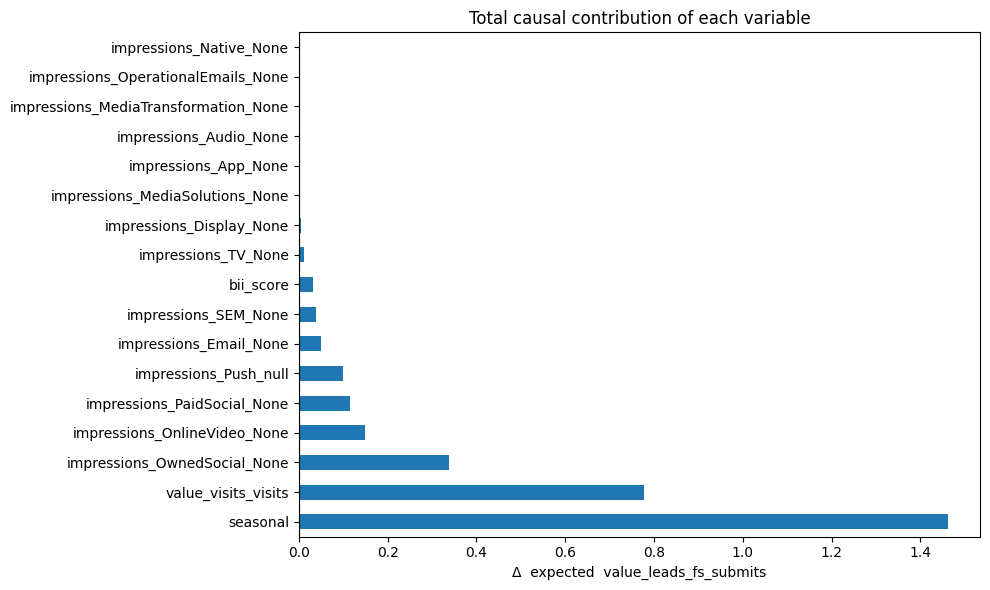

📊  saved → dv_total_effects.png


In [0]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pgmpy.inference import VariableElimination   # optional for spot-checks

# ------------------------------------------------------------------
# A.  choose your dependent variable (exact name from your DataFrame)
DV = "value_leads_fs_submits"

# ------------------------------------------------------------------
# B.  build the B matrix  (direct coefficients)
vars_ = list(lgbn.nodes())                 # lgbn is your fitted model
idx   = {v: i for i, v in enumerate(vars_)}
n     = len(vars_)

B = np.zeros((n, n))
for cpd in lgbn.get_cpds():               # each is LinearGaussianCPD
    child = cpd.variable
    β     = cpd.beta                      # [β0, β_parent1, …]
    parents = cpd.evidence
    for p, beta in zip(parents, β[1:]):   # skip intercept β0
        B[idx[child], idx[p]] = beta

# ------------------------------------------------------------------
# C.  total-effect matrix  T  (one shot, cheap)
T = np.linalg.inv(np.eye(n) - B) - np.eye(n)

# ------------------------------------------------------------------
# D.  pull the DV row  →  causal lift table
dv_row = T[idx[DV], :]
ace    = (pd.Series(dv_row, index=vars_, name="Δ" + DV + "  per +1 in X")
            .drop(DV)                     # exclude self-effect
            .sort_values(ascending=False))

print("\n=== Average causal contribution (one-unit do()) ===\n")
print(ace)

# ------------------------------------------------------------------
# E.  visualise
plt.figure(figsize=(10, 6))
ace.plot(kind="barh")
plt.axvline(0, color="k", linewidth=0.8)
plt.xlabel("Δ  expected  " + DV)
plt.title("Total causal contribution of each variable")
plt.tight_layout()
plt.savefig("dv_total_effects.png", dpi=160)
plt.show()
print("📊  saved → dv_total_effects.png")


In [0]:
delta = scaled['bii_score'].quantile(0.75) - scaled['bii_score'].quantile(0.25)
lift  = T[idx[DV], idx['bii_score']] * delta

In [0]:
lift

0.0005905766800842851


=== Average causal contribution (ΔDV per +1 in X) ===

seasonal                                1.877264
impressions_OwnedSocial_None            0.435491
impressions_OnlineVideo_None            0.192005
impressions_PaidSocial_None             0.148841
impressions_Push_null                   0.128685
impressions_Email_None                  0.063749
impressions_SEM_None                    0.050365
bii_score                               0.040567
impressions_TV_None                     0.015153
impressions_Display_None                0.006185
impressions_MediaSolutions_None         0.000631
impressions_App_None                    0.000089
impressions_OperationalEmails_None      0.000000
impressions_Audio_None                  0.000000
impressions_MediaTransformation_None    0.000000
impressions_Native_None                 0.000000
value_leads_fs_submits                  0.000000
dtype: float64


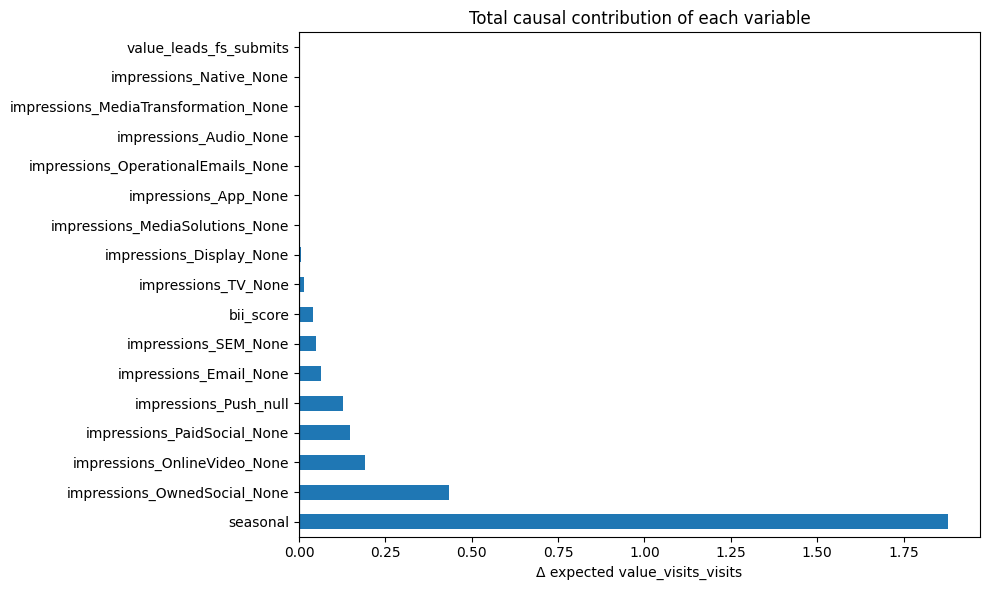

In [0]:
DV = "value_visits_visits"          # your dependent variable

# total causal effects, all paths included
T = np.linalg.inv(np.eye(len(B)) - B) - np.eye(len(B))

ace = (pd.Series(T[idx[DV], :], index=vars_)
         .drop(DV)                       # remove self-effect
         .sort_values(ascending=False))

print("\n=== Average causal contribution (ΔDV per +1 in X) ===\n")
print(ace)

# visualise
ace.plot(kind="barh", figsize=(10,6))
plt.axvline(0, color="k"); plt.xlabel("Δ expected " + DV)
plt.title("Total causal contribution of each variable")
plt.tight_layout(); plt.savefig("dv_total_effects.png", dpi=160); plt.show()


In [0]:
# -----------------------------------------------
# vars_  : list of node names in a fixed order
# idx    : dict {node → row/column index}
# lgbn   : your fitted LinearGaussianBayesianNetwork
# -----------------------------------------------

# 1️⃣  allocate the vector
c = np.zeros(len(vars_))

# 2️⃣  loop over every CPD and drop β₀ into the right slot
for cpd in lgbn.get_cpds():             # each is LinearGaussianCPD
    child = cpd.variable
    beta0 = cpd.beta[0]                 # first entry is the intercept
    c[idx[child]] = beta0               # place it into the vector

# now  c  ==  [β0_node1, β0_node2, …]  consistent with B and T


In [0]:
# ------------------------------------------------------------------
# helper: steady-state mean implied by the LG-BN
inv_I_minus_B = np.linalg.inv(np.eye(len(B)) - B)
mu_model      = inv_I_minus_B @ c             # vector of means

# ------------------------------------------------------------------
# pick the driver we’re testing
X = "bii_score"
DV = "value_visits_visits"

# 1.  T-matrix causal lift  (already correct)
lift_T = T[idx[DV], idx[X]]                   # one-unit do()

# 2.  Direct recomputation using the structural equations
delta  = 0.01                                  # +1 unit intervention
mu_plus = inv_I_minus_B @ (c + B[:, idx[X]] * delta)
lift_direct = mu_plus[idx[DV]] - mu_model[idx[DV]]

print("T-matrix lift :", lift_T)
print("Direct-μ lift :", lift_direct)


T-matrix lift : 0.040566705031822275
Direct-μ lift : 0.0004056670503183035


In [0]:
0.0004056670503183035*np.mean(aggregated['value_visits_visits'])

290319.38311324065

In [0]:
290319.38311324065*100/701033118.5263158

0.041413076706495494

A 0.01 increase in bii_score can move the visits by 290k which is approximately 0.04% of total visits we get in a month

In [0]:
# ------------------------------------------------------------------
# helper: steady-state mean implied by the LG-BN
inv_I_minus_B = np.linalg.inv(np.eye(len(B)) - B)
mu_model      = inv_I_minus_B @ c             # vector of means

# ------------------------------------------------------------------
# pick the driver we’re testing
X = "bii_score"
DV = "value_leads_fs_submits"

# 1.  T-matrix causal lift  (already correct)
lift_T = T[idx[DV], idx[X]]                   # one-unit do()

# 2.  Direct recomputation using the structural equations
delta  = 0.01                                  # +1 unit intervention
mu_plus = inv_I_minus_B @ (c + B[:, idx[X]] * delta)
lift_direct = mu_plus[idx[DV]] - mu_model[idx[DV]]

print("T-matrix lift :", lift_T)
print("Direct-μ lift :", lift_direct)

T-matrix lift : 0.03158050271407169
Direct-μ lift : 0.00031580502714079195


In [0]:
0.00031580502714079195*np.mean(aggregated['value_leads_fs_submits'])

348.93091246680143

A 0.01 increase in bii_score can move the FS Submits by 350 which is approximately 0.025% of total FS Submits we get in a month

In [0]:
i = 1

while i > 0:

    i = 1

INFO:root:Exception while sending command.
Traceback (most recent call last):
  File "/databricks/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/clientserver.py", line 527, in send_command
    self.socket.sendall(command.encode("utf-8"))
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/databricks/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/clientserver.py", line 530, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:132)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:132)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
aggregated['value_visits_visits'].sum()

12166207507.0

In [0]:
# Can I calculate the causation of this visits?

np.mean(aggregated['value_visits_visits'])

715659265.117647

In [0]:
# Let's run a Bayesian Model

import pymc as pm
import pandas as pd
import arviz as az

# ------------------------------------------------------------------
# 1.  Ensure the data are in chronological order and have no gaps
#     (17 monthly rows expected)
#df = scaled.sort_values("month").reset_index(drop=True)

# 2.  Pull the columns you care about
fs_subs       = scaled["value_leads_fs_submits"].values          # y_t
visits       = scaled["value_visits_visits"].values          # y_t
brand_metric = scaled["bii_score"].values                    # X_t
tv = scaled['impressions_TV_None'].values
seasonal = scaled['seasonal'].values
sem = scaled['impressions_SEM_None'].values
paid_social = scaled['impressions_PaidSocial_None'].values
y_lag        = pd.Series(visits).shift(1).values         # y_{t-1}

# 3.  Drop the first row (no lag available)
mask         = ~pd.isna(y_lag)
fs_subs       = fs_subs[mask]
visits       = visits[mask]
brand_metric = brand_metric[mask]
tv = tv[mask]
seasonal = seasonal[mask]
sem = sem[mask]
paid_social = paid_social[mask]
y_lag        = y_lag[mask]

# ------------------------------------------------------------------
# 4.  Bayesian Koyck model with soft-positive prior on θ
with pm.Model() as brand_koyck:
    theta = pm.HalfNormal("theta", sigma=0.05)           # immediate lift ≥ 0
    lam   = pm.Beta("lam", alpha=2, beta=2)              # 0 < λ < 1
    sigma = pm.HalfNormal("sigma", sigma=1.0)
    betaM = pm.LogNormal("beta_media", mu=0, sigma=1, shape=3) 
    seasonalB = pm.LogNormal("seasonal_beta", mu=0, sigma=1)
    visitsB = pm.LogNormal("visits_beta", mu=0, sigma=1) 

    mu = theta * brand_metric + lam * y_lag + betaM[0] * tv  +  betaM[1]*sem + betaM[2]*paid_social +  seasonalB*seasonal + visitsB*visits
    pm.Normal("y", mu=mu, sigma=sigma, observed=fs_subs)

    trace = pm.sample(3000, tune=1000, chains=4,
                      target_accept=0.9, random_seed=44)

# ------------------------------------------------------------------
# 5.  Summarise the key parameters
summary = az.summary(trace, var_names=["theta","lam","beta_media","seasonal_beta"], round_to=4)
print(summary)

# 6.  Compute long-run multiplier and half-life
theta_hat = trace.posterior["theta"].mean().item()
lam_hat   = trace.posterior["lam"].mean().item()

long_run  = theta_hat / (1 - lam_hat)
half_life = np.log(0.5) / np.log(lam_hat)        # in months

print(f"\nPosterior mean immediate lift θ   : {theta_hat:.4f}")
print(f"Posterior mean carry-over λ        : {lam_hat:.4f}")
print(f"Long-run lift θ/(1-λ)              : {long_run:.4f}")
print(f"Half-life (months)                 : {half_life:.2f}")

INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:NUTS: [theta, lam, sigma, beta_media, seasonal_beta, visits_beta]


Output()

INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 7 seconds.


                 mean      sd  hdi_3%  ...    ess_bulk   ess_tail   r_hat
theta          0.0316  0.0255  0.0000  ...   8806.8296  4596.8106  1.0000
lam            0.1650  0.1045  0.0060  ...  14273.6345  7425.7518  1.0003
beta_media[0]  0.1516  0.0787  0.0264  ...  11176.6467  6698.0197  1.0002
beta_media[1]  0.1572  0.0836  0.0265  ...  13182.8941  7927.2048  1.0003
beta_media[2]  0.1778  0.0940  0.0327  ...  13199.1277  7283.8304  1.0001
seasonal_beta  0.1800  0.0803  0.0394  ...  13399.4791  7718.7797  1.0000

[6 rows x 9 columns]

Posterior mean immediate lift θ   : 0.0316
Posterior mean carry-over λ        : 0.1650
Long-run lift θ/(1-λ)              : 0.0379
Half-life (months)                 : 0.38


In [0]:
0.0316*0.01*np.mean(aggregated['value_leads_fs_submits'])

349.14633670588233

In [0]:
hdi = az.hdi(trace, var_names=["theta","lam"], hdi_prob=0.9)
print(hdi)

<xarray.Dataset> Size: 80B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    theta    (hdi) float64 16B 0.001828 0.1124
    lam      (hdi) float64 16B 0.6912 0.9717


In [0]:
# What does this say?